## Projecting capital stock values (2020-2100) according to Dellink et al. (2017)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product as lstprod

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import xarray as xr
from sliiders import settings as sset
from sliiders.io import open_zarr, save

TRANSITION_YEAR = 2010

## Capital projection

We incorporate historical 2000-20 capital stock values and projected GDP, GDPpc, and population values.

### Importing and merging capital values

In [3]:
# historical data and projected gdp, gdppc, and population
hist_da = pd.read_parquet(sset.PATH_EXPOSURE_YPK_COUNTRY_HIST_INT).to_xarray()
proj_ypk_da = open_zarr(sset.PATH_EXPOSURE_YPK_COUNTRY_PROJ_INT, chunks=None)

# combine
proj_ypk_da["gdp"] = proj_ypk_da.gdppc * proj_ypk_da["pop"]

# set initial capital from historical data
proj_ypk_da["capital"] = hist_da.rnna_19.reindex(year=proj_ypk_da.year)

### Getting the historical overall GDP elasticity with respect to capital

We first need to calculate the overall GDP elasticity w.r.t. capital, and here we assume a simple Cobb-Douglas production function with population being an approximation of the labor force, and the years we consider are 2000-2010. Alternatively, we may use IIASA approximation (from Crespo Cuaresma, 2017) of the said elasticity being approximately 0.326.

In [4]:
# we use historical values (2000-2010), except for uninhabited areas
UNINH = sset.UNINHABITED_ISOS
log_recent = np.log(
    hist_da.drop_sel(ccode=UNINH).sel(year=sset.HISTORICAL_YEARS[-10:])[
        ["rnna_19", "rgdpna_19", "pop"]
    ]
)

OVERALL_E = (
    smf.ols(
        "rgdpna_19 ~ pop + rnna_19",
        data=log_recent.to_dataframe(),
    )
    .fit()
    .params["rnna_19"]
)
OVERALL_E_IIASA = 0.326
alpha_da = xr.DataArray(
    [OVERALL_E, OVERALL_E_IIASA], coords={"alpha_source": ["ours", "iiasa"]}
)

#### Calculating the initial marginal product of capital (${MPK}_{r, t_0}$, with $t_0 = 2010$) and appending other necessary information

**Four options of calculating MPK**

If we assume a simple, Cobb-Douglas form for the production function (i.e., $Y = AK^\alpha L^{1-\alpha}$), the marginal product of capital (MPK) can be written as:
$$ \frac{\partial Y}{\partial K} = \alpha \cdot \underbrace{A{K}^\alpha{L}^{1-\alpha}}_{=Y}\cdot \frac{1}{K} = \alpha \frac{Y}{K} = \alpha \frac{Y/L}{K/L} $$
and similarly if we are going to assume some form like $Y = AK^\alpha$, we can write:
$$ \frac{\partial Y}{\partial K} = \alpha \cdot \underbrace{AK^{\alpha}}_{=Y} \cdot \frac{1}{K} = \alpha \frac{Y}{K} $$
so essentially the MPK can be written as the ratio of GDP ($Y$) and capital ($K$) multiplied by the GDP elasticity w.r.t. capital ($\alpha$).

We have acquired two different estimates (one ours, one IIASA's) of $\alpha$ from above, but we can further look at calculating $\alpha$ for each country by fitting either a Cobb-Douglas function or a capital-only function. So there are four options for calculating a country's MPK:
1. Use $\alpha$ from IIASA
2. Use $\alpha$ from our estimation
3. Use $\alpha$ from fitting a Cobb-Douglas function
4. Use $\alpha$ from fitting a capital-only function

and we can multiply the value of $\frac{Y}{K}$ (in the year 2010) afterwards.

In [5]:
# get projected y/k ratio in 2020 for ssp2
tmp = proj_ypk_da.sel(year=sset.HISTORICAL_YEARS[-1], ssp="SSP2", drop=True)
yk_ratio = (tmp.gdp / tmp.capital).dropna("ccode")

# mpk using global elasticities
mpk_init_our = yk_ratio * OVERALL_E
mpk_init_cuaresma = yk_ratio * OVERALL_E_IIASA
mpk_init = [mpk_init_our, mpk_init_cuaresma]

for name, reg_vars in [("cap_only", ["rnna_19"]), ("cap_labor", ["rnna_19", "pop"])]:
    i_ols = smf.ols(
        "rgdpna_19 ~ C(ccode) + " + " + ".join([f"C(ccode):{v}" for v in reg_vars]),
        data=log_recent.to_dataframe().reset_index(),
    ).fit()

    elas_k = i_ols.params[i_ols.params.index.str.contains("rnna_19")].rename("elas_k")
    elas_k.index = pd.Index(elas_k.index.str.split(":").str[0].str[-4:-1], name="ccode")
    elas_k = elas_k.to_xarray()

    # using country-specific elasticities
    mpk_init.append(yk_ratio * elas_k)

mpk_init = xr.concat(
    mpk_init, dim=pd.Index(["ours", "iiasa", "ctry_co", "ctry_cd"], name="kind")
)

# there are some cases in which MPK values are found to be nonpositive (capital stock is
# ineffective in increasing GDP); in this case, we will clip it with
# the minimum MPK garnered either from `mpk_our`, `mpk_iiasa`, or itself (whichever
# is lesser yet above 0)
mpk_init = mpk_init.where(mpk_init > 0, mpk_init.where(mpk_init > 0).min("kind"))

# initializing the PIM process
proj_ypk_da = proj_ypk_da.assign(
    yk=yk_ratio,
    mpk=mpk_init.expand_dims(year=sset.HISTORICAL_YEARS).reindex(year=proj_ypk_da.year),
    alpha=alpha_da,
).fillna(0)

### Using the perpetual inventory method (PIM) with the dynamic parameter equations specified in Dellink et al. (2017)

The method in Dellink et al. (2017) is basically a PIM, but its parameters are dynamic (and evolving on their own) so that they converge to specific long-term values. Below is an application of the Dellink et al. (2017) methodology using the MPKs (in 4 different methods) we have calculated above for each country.

First, we load the 2010 historical values (some estimated) of capital stock into our projection dataset. Also, we calculate the by-country average depreciation rates (from PWT 10.0) and overall average (average of the by-country rates) rates (also from PWT 10.0) which are used in the PIM process. If a country is missing from the PWT 10.0 dataset, we will simply use the overall average depreciation rate for the country-specific values.

In [6]:
# importing the initial iy ratios and delta as average of 2010-2020
# one reason for taking the average is, there might be some countries with
# negative iy ratio, which is possible, but when starting with that value may cause
# end-of-century capital stock to be negative
iy_org = (
    hist_da[["iy", "delta"]]
    .sel(year=sset.HISTORICAL_YEARS[-10:])
    .mean("year")
    .rename(delta="delta_c", iy="iy_ratio")
)

# If countries still have negative iy ratio, swap this with smallest positive iy
# Note that IY=0 for countries without any investment or population
iy_posmin = iy_org.iy_ratio.where(iy_org.iy_ratio > 0).min()
iy_org = iy_org.assign(iy_ratio=np.maximum(iy_org.iy_ratio, iy_posmin))

# AFG has the average delta value
delta_overall = iy_org.sel(ccode="AFG").delta_c

# merge this with the 2010 (starting point) dataset
proj_ypk_da = xr.merge((proj_ypk_da, iy_org))
proj_ypk_da["delta"] = delta_overall

In [7]:
# getting the ccodes and ccode-specific DFs necessary
# UMI had population in historical data but is uninhabited now
ccodes_pos_y = proj_ypk_da.where(
    (proj_ypk_da.gdp != 0) & (proj_ypk_da.ccode != "UMI"), drop=True
).ccode.values.tolist()

# splitting into inhabited vs. uninhabited
cc_uninh = proj_ypk_da.drop_sel(ccode=ccodes_pos_y)
cc = proj_ypk_da.sel(ccode=ccodes_pos_y)

In [8]:
# (1 - convergence rate to "average" marginal product of capital)
GAMMA_MPK = 0.985

# "average" marginal product of capital
MPK_BAR = 0.1

# (1 - convergence to long-run investment-gdp ratio)
GAMMA_I = 0.98

In [9]:
# set up converging MPK
for y in np.arange(sset.HISTORICAL_YEARS[-1] + 1, sset.PROJ_YEARS[-1] + 1):
    cc["mpk"].loc[{"year": y}] = (
        GAMMA_MPK * cc.mpk.sel(year=y - 1, drop=True) + (1 - GAMMA_MPK) * MPK_BAR
    )

# calculate long-term capital-gdp ratio
cc["ky_LT"] = cc.alpha / cc.mpk

# calculate GDP growth
cc["gdp_gr"] = ((cc.gdp.shift(year=-1) / cc.gdp) - 1).ffill("year")

# calculate long-term investment-gdp ratio
cc["iy_LT"] = (cc.gdp_gr + cc.delta) * cc.ky_LT

# calculate instantaneous I-to-Y ratios time series and capital
cc["IY"] = cc.iy_ratio.broadcast_like(cc).copy()
cc["capital"] = cc.capital.broadcast_like(cc).copy()
for yr in np.arange(sset.HISTORICAL_YEARS[-1] + 1, sset.PROJ_YEARS[-1] + 1):
    # calc I:Y
    this_IY = (GAMMA_I * cc.IY.sel(year=yr - 1)) + (1 - GAMMA_I) * cc.iy_LT.sel(year=yr)
    cc["IY"].loc[{"year": yr}] = this_IY

    # calc capital from depreciation and investment
    cc["capital"].loc[{"year": yr}] = (
        (1 - cc.delta_c) * cc.capital.sel(year=yr - 1) + this_IY * cc.gdp.sel(year=yr)
    ).transpose(*[d for d in cc.capital.dims if d != "year"])

# calculate capital to GDP ratios
cc["KY"] = cc.capital / cc.gdp

### Checking against the Dellink et al. (2017)'s Figure 6 (capital intensity plots)

We examine our 6 options as below. After examination with the graph as well as the SSE values, it seems that the case utilizing **by-country MPK using capital-only production** and **overall capital elasticity from IIASA**. Thus, we use this specification to reflect our best replication of Dellink et al.

In [10]:
def examine_against_fig6(capital_da, intensity="KY", fig_size=(18, 9)):
    """
    Function to examine the estimated capital intensity (the variable `intensity` in the
    DataFrame `pim_df`) against the Dellink et al. (2017) output of the same variable
    for four countries Tanzania, India, China, and the United States (shown in Fig. 6 of
    the paper). Also calculates the SSE across own estimates and Dellink et al. (2017)'s
    numbers.

    Parameters
    ----------
    capital_da : :py:class:`xarray.Dataset`
        containing the `intensity` variable; should have indices `ccode`, `year`,
        `ssp`, and `iam` (in that order)
    intensity : str
        capital intensity variable in `pim_df`
    fig_size : tuple of floats or ints
        to set the output figure size

    Returns
    -------
    sse : float
        SSE (w.r.t. Dellink et al. (2017) Figure 6) calculated
    also, presents the bar graphs (containing capital intensity values from data)
        plotted in comparison to Dellink et al. (2017) Figure 6

    """

    FOUR_CTRIES = ["TZA", "IND", "CHN", "USA"]
    SSP = ["SSP{}".format(x) for x in range(5, 0, -1)]
    FIG_YRS = [2100, 2050, 2020]

    # preparing the figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    which = np.arange(0.1, 15 * 0.5 + 0.1, 0.5)
    which = which + np.array(range(0, len(which))) * 0.1

    # from Dellink et al. (2017); had to measure the figure with a ruler
    ky_cm = 3 / 6.525
    dellink_case = pd.DataFrame(
        list(lstprod(*[FOUR_CTRIES, FIG_YRS, SSP])), columns=["ccode", "year", "ssp"]
    )
    dellink_case[intensity] = np.nan
    dellink_case["year"] = dellink_case["year"].astype("int64")
    dellink_case.set_index(["ccode", "year", "ssp"], inplace=True)

    # Values from Figure 6, in the order of SSP5 -> SSP1 and 2100, 2050, 2020
    TZN = [
        np.array([6.2, 4.45, 4.4]) * ky_cm,
        np.array([6.95, 6.1, 4.475]) * ky_cm,
        np.array([6.25, 5.675, 4.5]) * ky_cm,
        np.array([5.95, 5.175, 4.45]) * ky_cm,
        np.array([6.25, 4.65, 4.45]) * ky_cm,
    ]
    IND = [
        np.array([7.4, 5.7, 5.75]) * ky_cm,
        np.array([7.575, 6.7, 5.8]) * ky_cm,
        np.array([7.65, 7.45, 5.85]) * ky_cm,
        np.array([7.3, 6.525, 5.775]) * ky_cm,
        np.array([7.6, 5.95, 5.75]) * ky_cm,
    ]
    CHN = [
        np.array([9.9, 8.45, 6.35]) * ky_cm,
        np.array([10.25, 9.55, 6.475]) * ky_cm,
        np.array([9.8, 10.55, 6.525]) * ky_cm,
        np.array([9.6, 9.55, 6.45]) * ky_cm,
        np.array([10.45, 8.8, 6.4]) * ky_cm,
    ]
    USA = [
        np.array([6.25, 5.4, 5.05]) * ky_cm,
        np.array([6.75, 5.9, 5.1]) * ky_cm,
        np.array([7.275, 6.325, 5.15]) * ky_cm,
        np.array([6.9, 6.05, 5.1]) * ky_cm,
        np.array([6.65, 5.8, 5.1]) * ky_cm,
    ]
    for i, ct in enumerate([TZN, IND, CHN, USA]):
        ctry = FOUR_CTRIES[i]
        for j, row in enumerate(ct):
            ssp = SSP[j]
            dellink_case.loc[(ctry, FIG_YRS, ssp), intensity] = row

    labs = []
    for j, ssp in enumerate(SSP):
        labs += ["2100", "{}   2050".format(ssp), "2020"]

    ax1.set_yticks(which + 0.15)
    ax1.set_yticklabels(labs)
    dellink_vals = []
    for ix, ctry in enumerate(FOUR_CTRIES):
        ctry_vals = []
        for ssp in SSP:
            ctry_vals += list(dellink_case.loc[(ctry, FIG_YRS, ssp), intensity].values)
        ax1.barh(which + ix * 0.1, ctry_vals, height=0.1, label=ctry)
        dellink_vals += ctry_vals
    ax1.legend()
    ax1.set_title("Capital intensities for selected countries, Dellink et al. (2017)")

    ax2.set_yticks(which + 0.15)
    ax2.set_yticklabels(labs)
    our_vals = []
    for ix, ctry in enumerate(FOUR_CTRIES):
        ctry_vals = []
        for ssp in SSP:
            ctry_vals += capital_da.sel(ccode=ctry, year=FIG_YRS, ssp=ssp, iam="OECD")[
                intensity
            ].values.tolist()
        ax2.barh(which + ix * 0.1, ctry_vals, height=0.1, label=ctry)
        our_vals += ctry_vals

    mx = max(our_vals + dellink_vals)
    ax_set = np.linspace(0, np.ceil(mx), 5)
    sse = ((np.array(our_vals) - np.array(dellink_vals)) ** 2).sum()
    sser = round(sse, 3)

    ax1.set_xticks(ax_set)
    ax2.set_xticks(ax_set)

    ax2.legend()
    ax2.set_title("Capital intensities, our own replication using the OECD method")

    fig.suptitle("Comparison of capital intensities; SSE={}".format(sser), fontsize=12)
    fig.show()

    return sse


def top_bottom_10(da, yr=2100, ssp="SSP3"):
    """Shows the top ten and bottom ten capital estimates in the year `yr` and the SSP
    `ssp`; figures for IIASA and OECD IAMs are drawn separately.

    Parameters
    ----------
    da : :py:class:`xarray.Dataset`
        containing "capital" variable, with dims `ccode`, `year`, `ssp`, and `iam`.
    yr : int
        year in which we would like to compare the `capvar` values across countries
    ssp : str
        SSP scenario that we would like to examine
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))

    for i, ax in [("IIASA", ax1), ("OECD", ax2)]:
        this = da.sel(year=yr, ssp=ssp, iam=i)
        this = this.sortby(this)
        sma_vals = np.log(this.isel(ccode=slice(10)))
        small = list(range(1, 11))
        ax.barh(
            np.arange(1, 11),
            sma_vals,
            label="Bottom 10",
            color="orange",
            height=0.8,
        )
        ax.set_yticks(small)
        ax.set_yticklabels(sma_vals.ccode.values)

        big_vals = np.log(this.isel(ccode=slice(-10, None)))

        big = list(range(11, 21))
        ax.barh(big, big_vals, label="Top 10", color="#87CEEB", height=0.8)
        ax.set_yticks(small + big)
        ax.set_yticklabels(
            np.concatenate((sma_vals.ccode.values, big_vals.ccode.values))
        )
        fig.suptitle(f"Log of capital stock in the year {yr} and {ssp} scenario")
        ax.set_title(f"Case for {i}")
        ax.set_xlabel("Log of millions of dollars")

    fig.show()

    return None

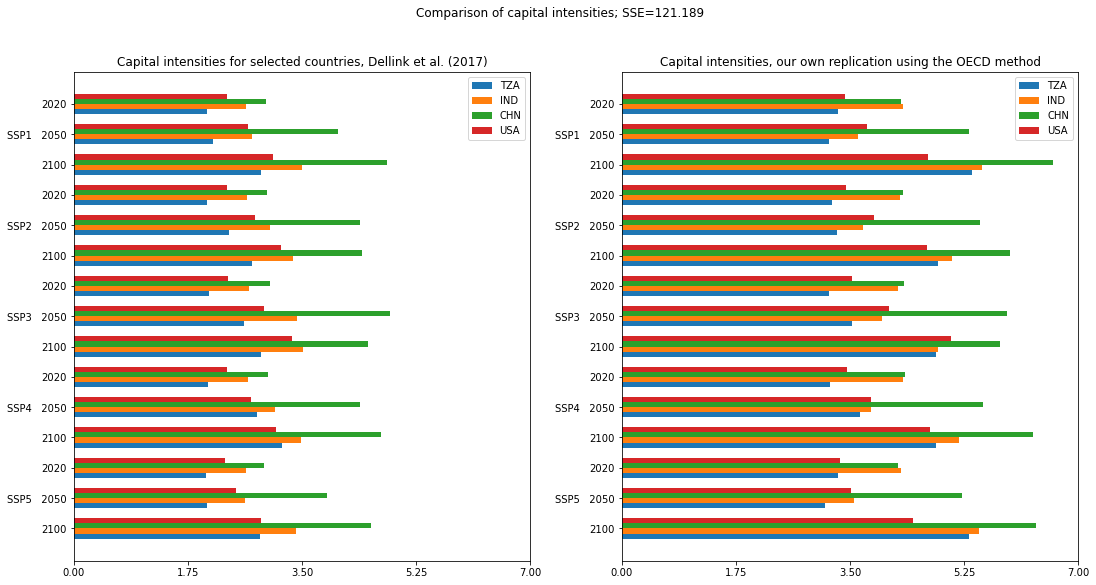

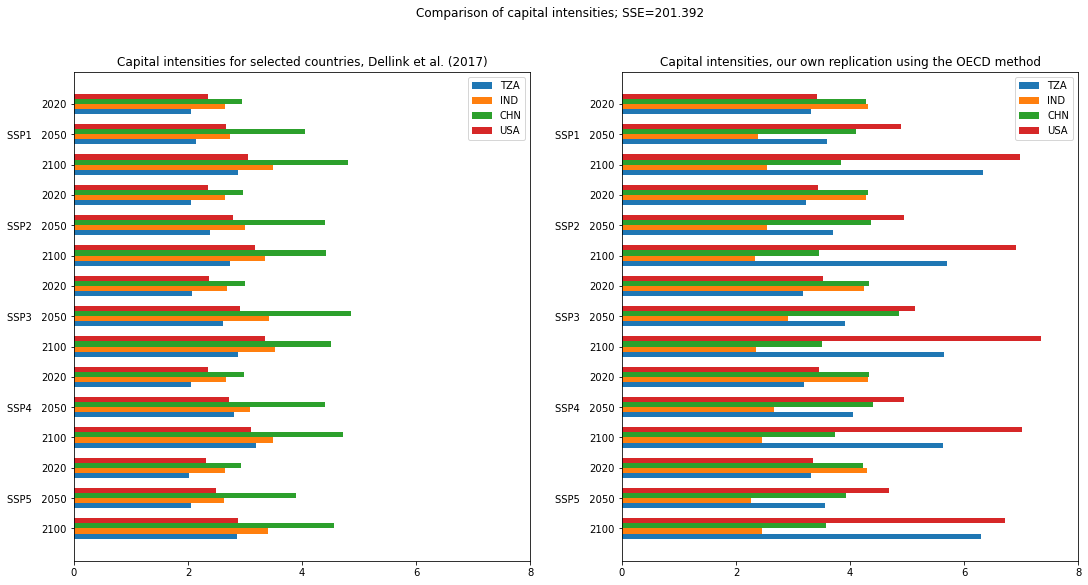

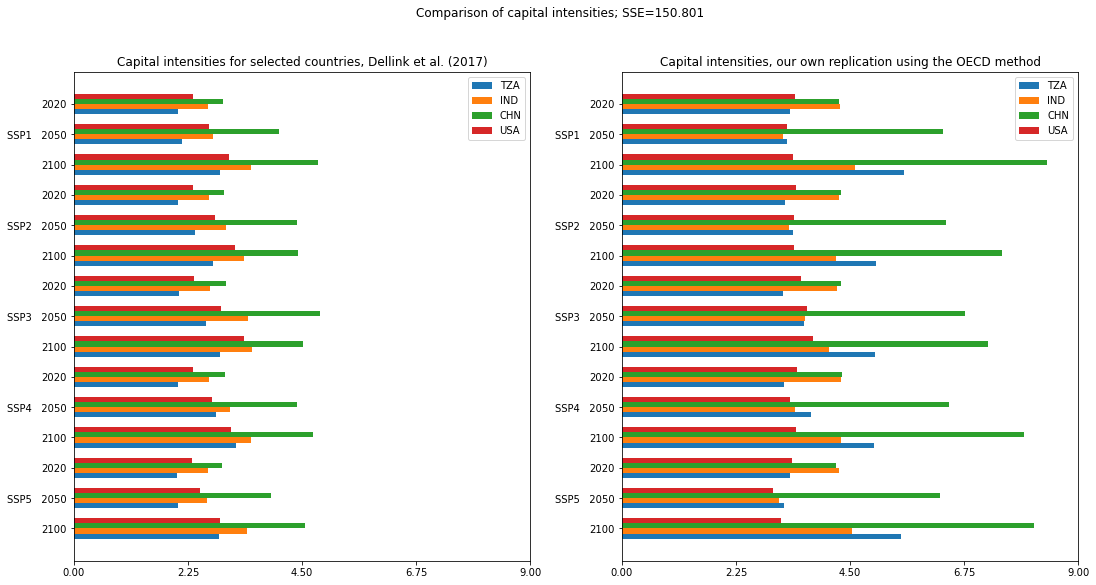

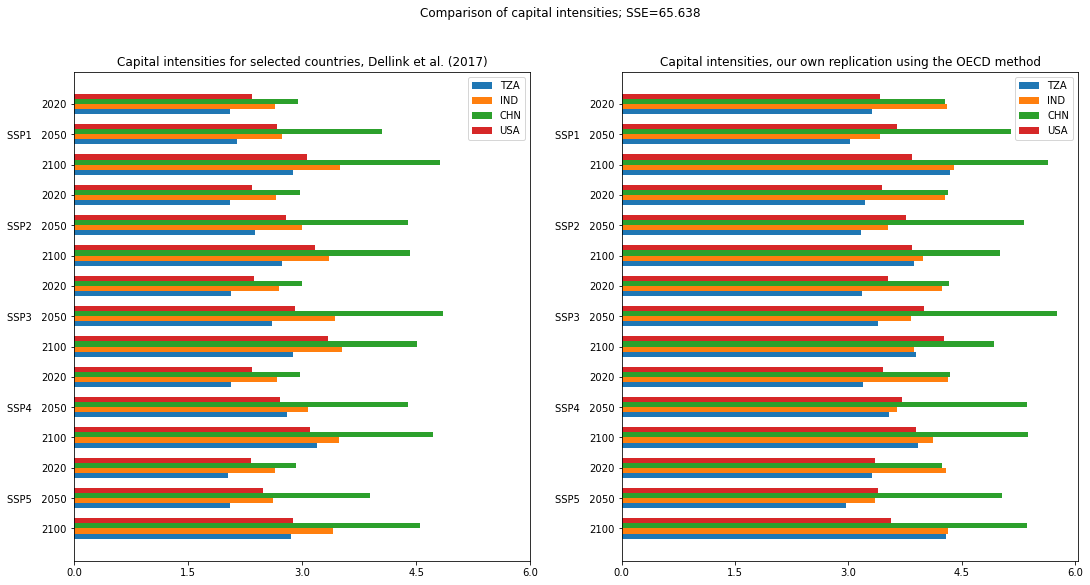

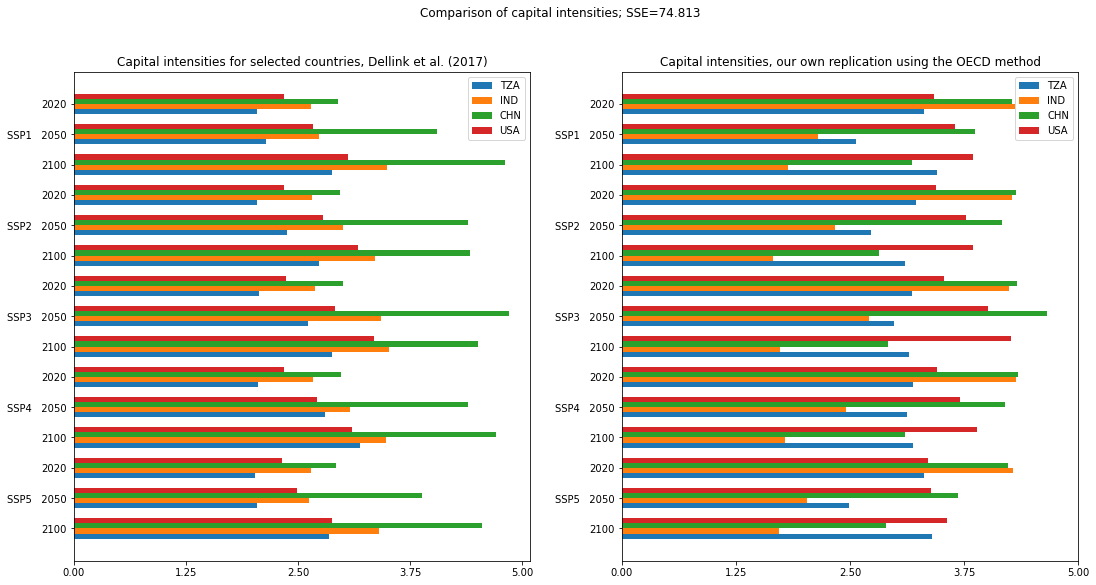

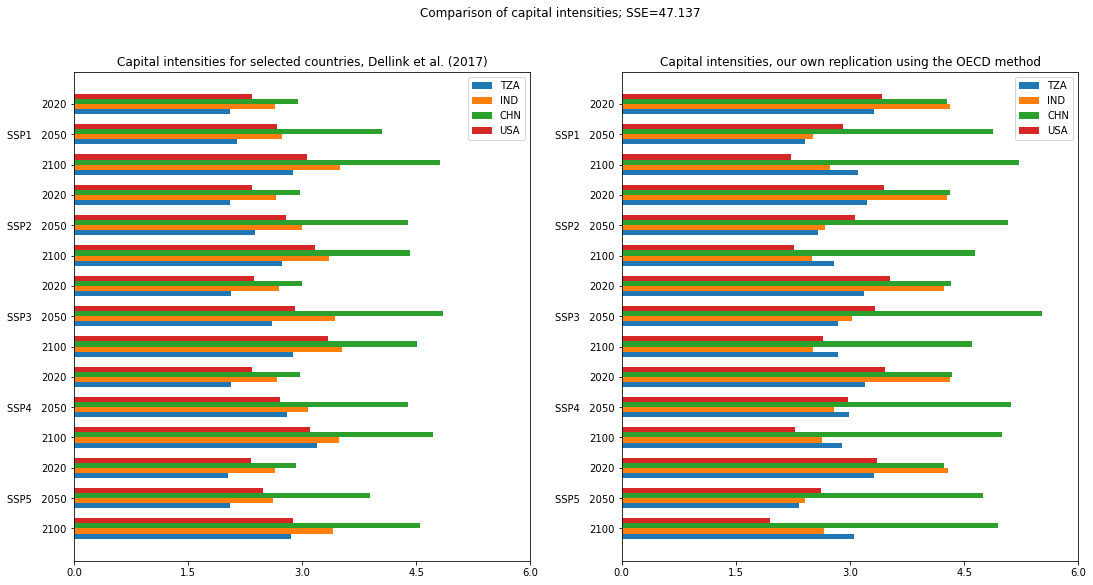

In [11]:
sses = []
lit_cases = [
    "Overall capital elas.: self-calculated, MPK: using overall cap. elas.",
    "Overall capital elas.: self-calculated, MPK: using indiv. cap. elas. (Cobb-Doug)",
    "Overall capital elas.: self-calculated, MPK: using indiv. cap. elas. (cap. only)",
    "Overall capital elas.: IIASA, MPK: using overall cap. elas.",
    "Overall capital elas.: IIASA, MPK: using indiv. cap. elas. (Cobb-Doug)",
    "Overall capital elas.: IIASA, MPK: using indiv. cap. elas. (cap. only)",
]

dict_cases = [
    {"alpha_source": "ours", "kind": "ours"},
    {"alpha_source": "ours", "kind": "ctry_cd"},
    {"alpha_source": "ours", "kind": "ctry_co"},
    {"alpha_source": "iiasa", "kind": "iiasa"},
    {"alpha_source": "iiasa", "kind": "ctry_cd"},
    {"alpha_source": "iiasa", "kind": "ctry_co"},
]
for ix, i in enumerate(lit_cases):
    sses.append(examine_against_fig6(cc.sel(dict_cases[ix], drop=True)))

For sanity check, we will also graph top and bottom ten cases of capital stock (in natural logarithm) for some specified SSP (SSP3 below) and some year (2100 below).

In [12]:
final = cc.sel(alpha_source="iiasa", kind="ctry_co", drop=True)

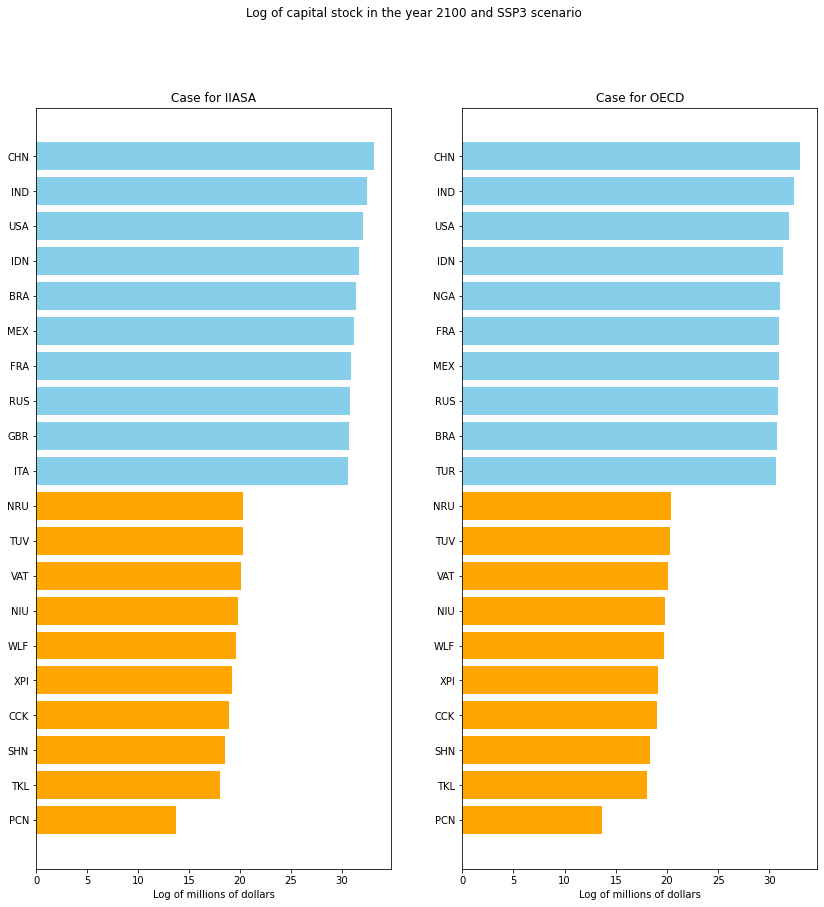

In [13]:
top_bottom_10(final.capital)

## Re-organizing the dataset and exporting

In [14]:
out = final[["pop", "gdppc", "capital", "mpk", "IY", "KY"]]

# add in uninhabited
out = xr.concat((out, out.reindex(ccode=cc_uninh.ccode, fill_value=0)), "ccode").sortby(
    "ccode"
)

In [15]:
for c in out.coords:
    if out[c].dtype == "object":
        out[c] = out[c].astype("unicode")

In [37]:
save(out, sset.PATH_EXPOSURE_YPK_COUNTRY_PROJ_INT, mode="w")